In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import xgboost, shap
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# **Step 1: get the data**

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv"

In [ ]:
median_income = '/content/drive/My Drive/X999/median_income_change.csv'

In [ ]:
idr_evi = '/content/drive/My Drive/X999/idr_evi.csv'

In [ ]:
median_income_df = pd.read_csv(median_income)
median_income_df.sort_values("income_change_ratio", ascending=False).head()

,Location,2005_median_income,2023_median_income,income_change,income_change_ratio,mediaon_income
63,Williamsburg/Greenpoint,46104.60315,111492.0,65387.39685,141.824010,78798.301575
11,Bushwick,38627.64912,78456.0,39828.35088,103.108400,58541.824560
17,Crown Heights North,45951.70330,91506.0,45554.29670,99.135165,68728.851650
26,Fort Greene/Brooklyn Hts,77383.97633,151134.0,73750.02367,95.303999,114258.988165
38,Mott Haven,21038.11098,33940.0,12901.88902,61.326271,27489.055490


In [ ]:
median_income_df.rename(columns={'mediaon_income': 'median_income'}, inplace=True)

In [ ]:
rows_to_drop = ['Brooklyn', 'Manhattan', 'Staten Island', 'Bronx', 'Queens']
median_income_df = median_income_df[~median_income_df['Location'].isin(rows_to_drop)]

In [ ]:
idr_evi_df = pd.read_csv(idr_evi)
idr_evi_df.shape

(66395, 131)

In [ ]:
df_analysis = pd.read_csv(file_path)

In [ ]:
df_analysis.shape

(66397, 102)

In [ ]:
# df_analysis.columns.to_list()

In [ ]:
df_temp = df_analysis[['primary_key', 'bin', 'building_category_ordinal', 'style_ordinal', 'building_age']]

In [ ]:
type(df_temp.bin[0]), type(idr_evi_df.bin[0])

(numpy.int64, numpy.int64)

In [ ]:
idr_evi_df = idr_evi_df.merge(df_temp, on='primary_key', how='left')

In [ ]:
idr_evi_df.shape

(66395, 135)

In [ ]:
idr_evi_df.head(1)

,Location,avg_idr,avg_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,bin_y,building_category_ordinal,style_ordinal,building_age
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,1077548,6,4,75.0


In [ ]:
idr_evi_df.rename(columns={'avg_change': 'avg_idr_change'}, inplace=True)

In [ ]:
# stop

In [ ]:
idr_evi_df = idr_evi_df.merge(median_income_df, on='Location', how='left')

In [ ]:
svi_variables = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white']
racial = ['ep_afam', 'ep_hisp']
building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age']
complaints_vars = ['air_quality', 'animal_issues', 'appliances', 'building_exterior', 'doors_windows', 'electrical_issues',
  'elevator_issues', 'floors_stairs', 'general_complaints', 'graffiti_posting', 'heat_hot_water', 'homeless_issues', 'noise_complaints',
  'other_issues', 'pest_issues', 'plumbing_issues', 'police_matters', 'public_nuisance',
  'safety_concerns', 'sanitation_issues', 'walls_ceilings','total_complaints']
dr_idr_var = ['avg_idr', 'avg_idr_change', 'income_change',	'income_change_ratio', 'median_income']

In [ ]:
idr_evi_df.is_condo[0].dtype

dtype('int64')

In [ ]:
is_condo_map = {
    True: 1,
    False: 0
}
idr_evi_df = idr_evi_df.replace({"is_condo": is_condo_map})
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,0,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [ ]:
is_llc_map = {
    True: 1,
    False: 0
}
idr_evi_df = idr_evi_df.replace({"is_llc": is_llc_map})
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,0,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [ ]:
all_vars = svi_variables + racial + building_vars + complaints_vars + dr_idr_var

In [ ]:
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,0,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [ ]:
idr_evi_df[all_vars].head()

,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,ep_afam,ep_hisp,numfloors,building_category_ordinal,unitsres,bldgarea,is_condo,is_llc,style_ordinal,building_age,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,avg_idr,avg_idr_change,income_change,income_change_ratio,median_income
0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,1.9,0.1,0.0,2.8,1.1,93.3,6.7,54.7,32.7,14.0,6,743.0,610785.0,0,0,4,75.0,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
1,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,743.0,610785.0,0,0,4,75.0,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
2,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,1861.0,1658649.0,0,0,4,75.0,0.0,16.0,0.0,0.0,6.0,0.0,14.0,0.0,0.0,0.0,0.0,10.0,1021.0,1.0,24.0,13.0,4.0,11.0,1.0,58.0,0.0,1179.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
3,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,5.0,6,18.0,20671.0,0,0,2,125.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,11.0,0.0,30.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,55.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
4,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,461.0,380833.0,0,0,4,75.0,1.0,3.0,0.0,0.0,16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,758.0,0.0,3.0,2.0,1.0,3.0,0.0,0.0,1.0,790.0,10.594985,7.277571,5956.73487,12.275533,51503.632565


# **Unit Level**

In [ ]:
X= idr_evi_df[all_vars]
y =idr_evi_df['average_year_eviction_count_per_unit(building)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# stop

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_svi.score(X_test, y_test)

0.9094833450767995

PermutationExplainer explainer: 501it [06:23,  1.27it/s]


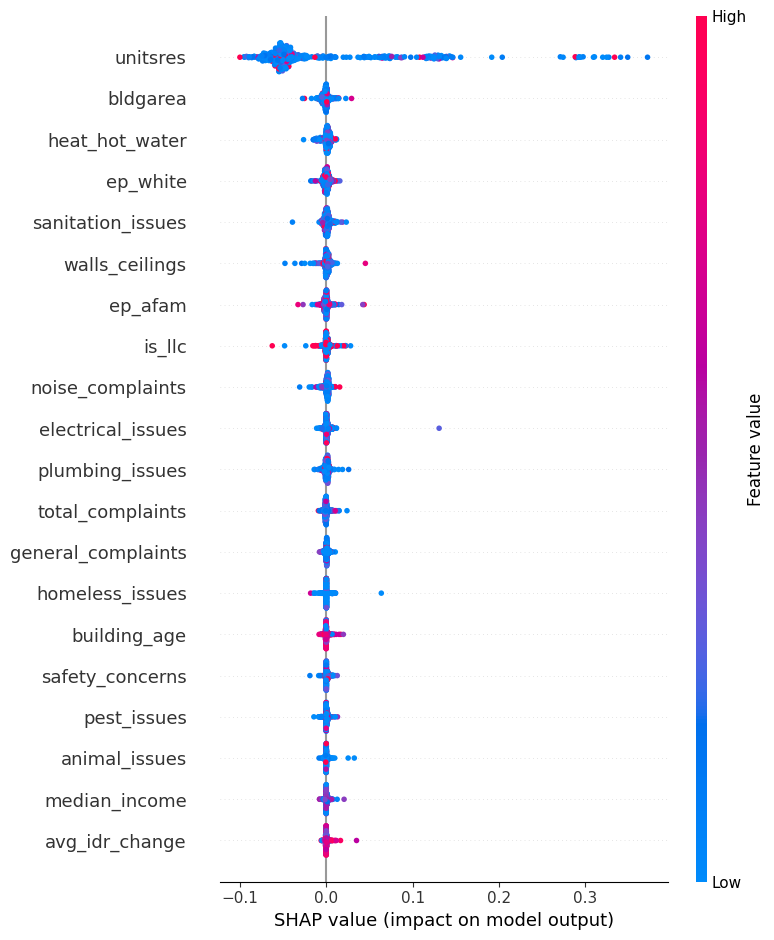

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

In [ ]:
# shap_values

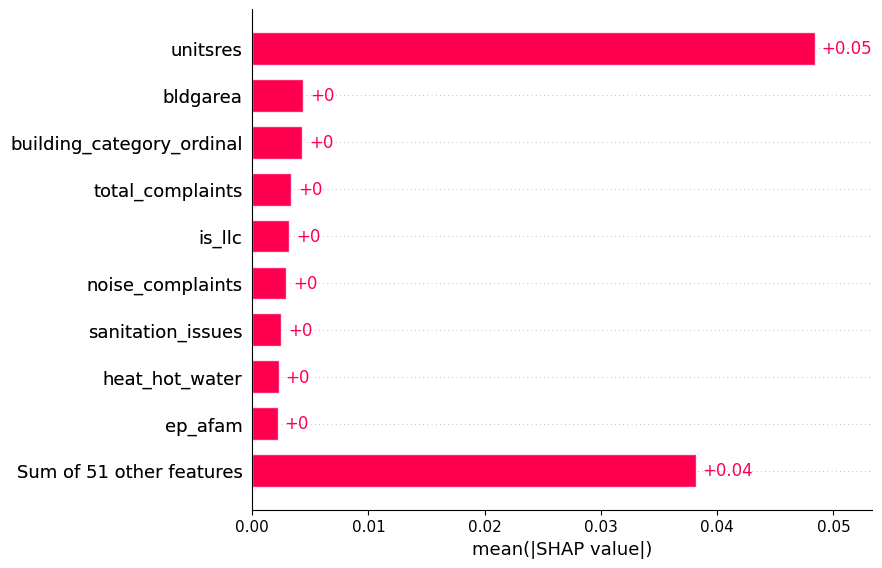

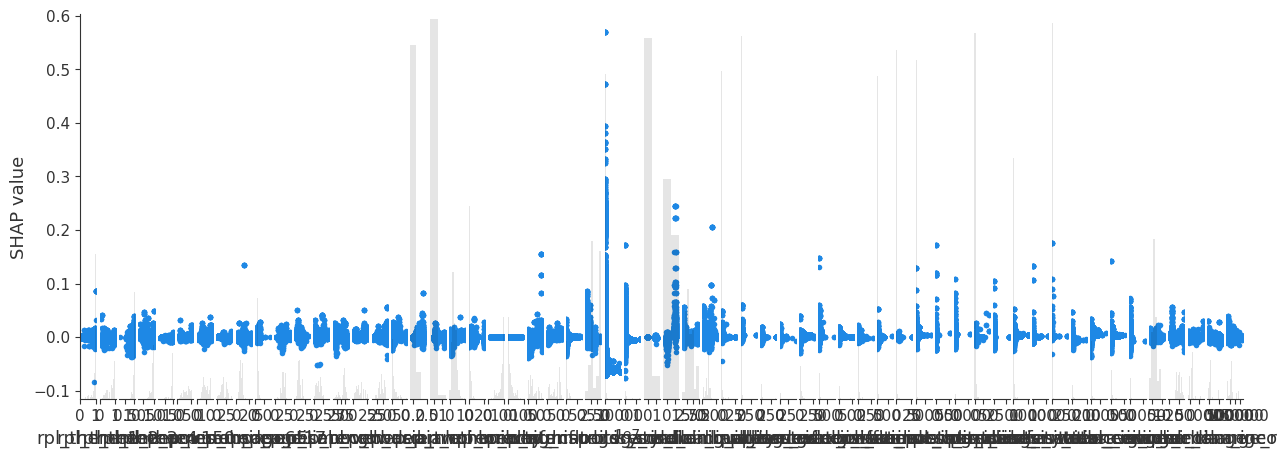

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [ ]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

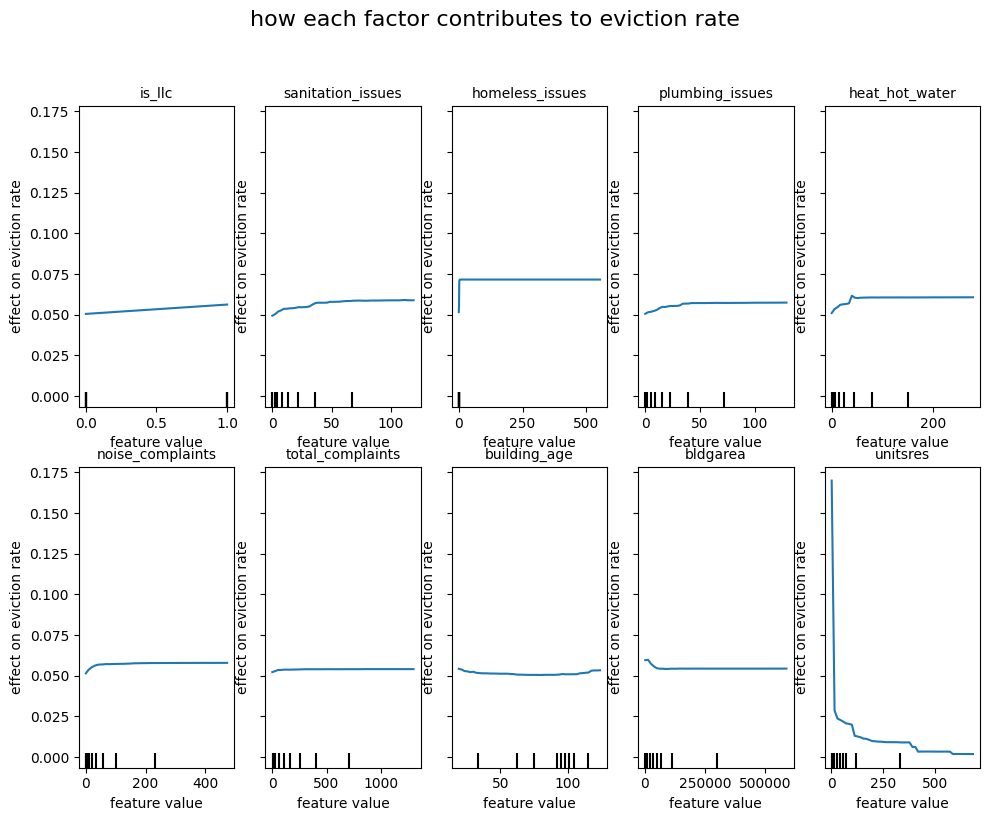

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Neighborhood Level**

In [ ]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [ ]:
idr_evi_df.shape

(66395, 140)

In [ ]:
X= idr_evi_df[all_vars]
y =idr_evi_df['eviction_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_svi.score(X_test, y_test)

0.9997263578953558

PermutationExplainer explainer: 501it [02:36,  2.99it/s]


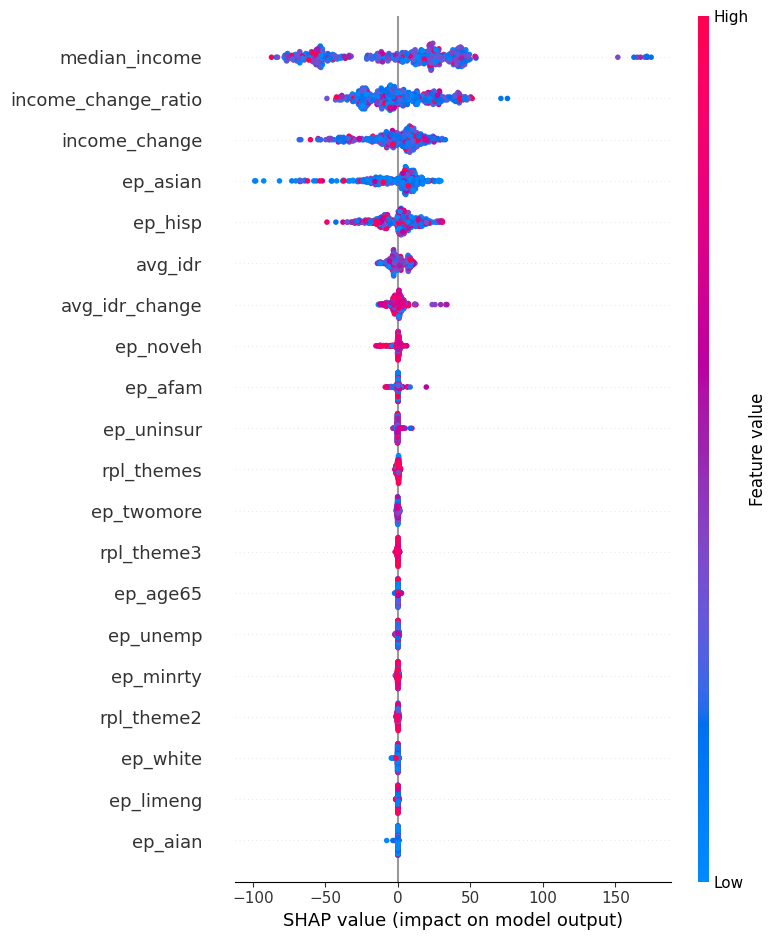

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

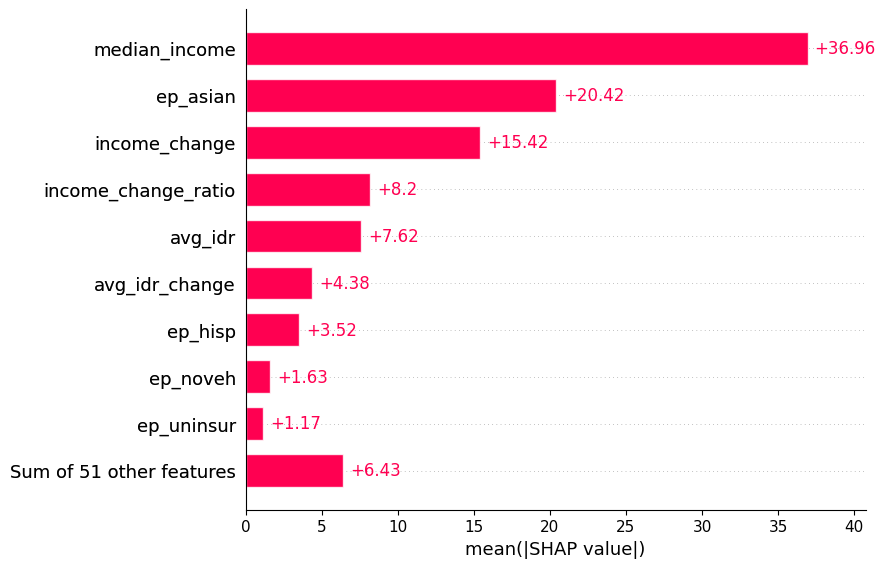

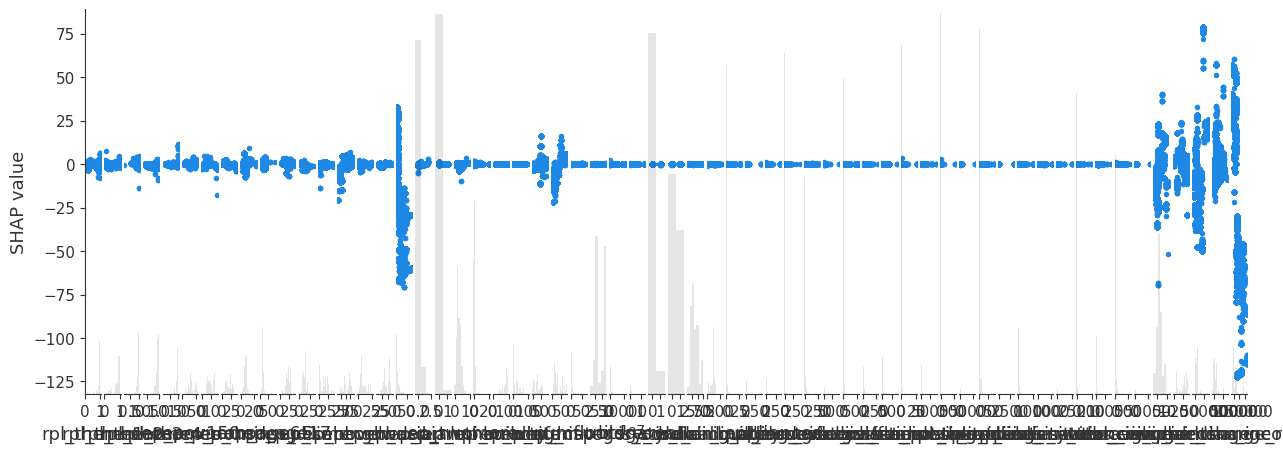

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)
shap.plots.scatter(shap_values)

In [ ]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

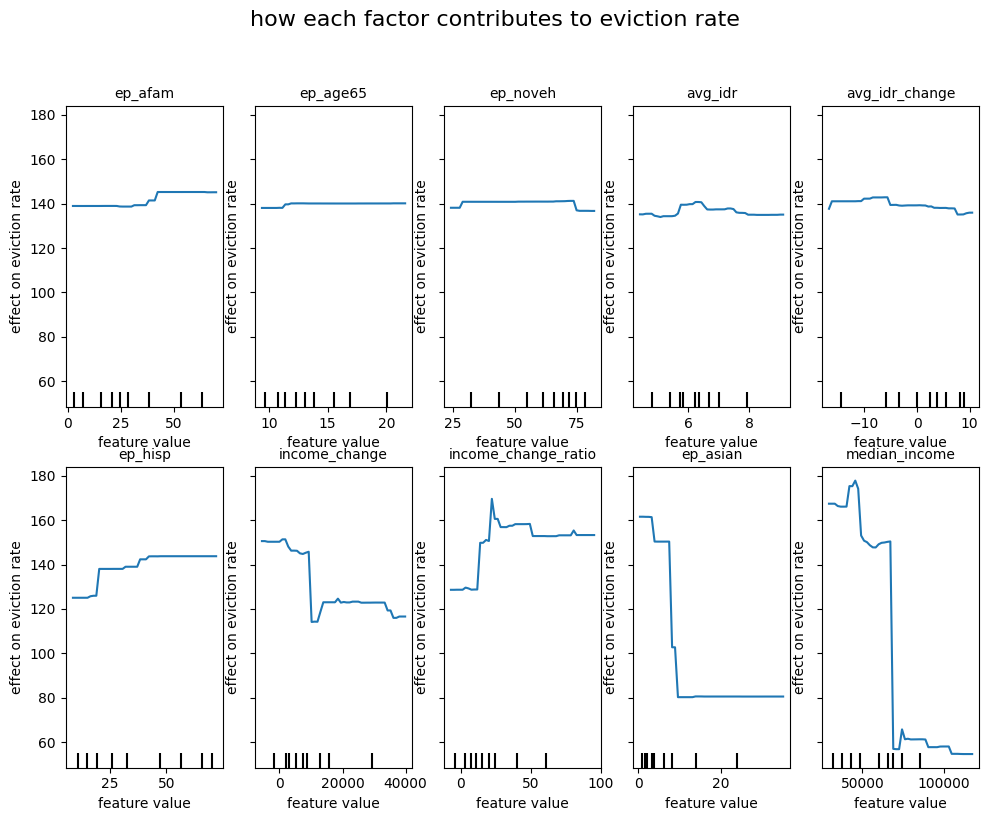

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

In [ ]:
# stop

## **Neighborhood Level**

In [ ]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [ ]:
# idr_evi_df_nta.shape

In [ ]:
# X= idr_evi_df_nta[all_vars]
# y= idr_evi_df_nta['eviction_count']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rfr_svi.fit(X_train, y_train)

In [ ]:
# model_rfr_svi.score(X_train, y_train)

In [ ]:
# # model.predict instead of model, faster
# explainer = shap.Explainer(model_rfr_svi.predict, X)
# # need to only select the first few hundreds of samples to run
# shap_values = explainer.shap_values(X.sample(n=58))
# shap.summary_plot(shap_values, X.sample(n=58))

In [ ]:
# model = xgboost.XGBRegressor()
# model.fit(X, y)

# explainer = shap.Explainer(model)
# shap_values = explainer(X)
# shap.plots.bar(shap_values)
# shap.plots.scatter(shap_values)

## **Zipcode Level**

In [ ]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [ ]:
# idr_evi_df_zipcode = idr_evi_df.drop_duplicates(subset=['zipcode'])

In [ ]:
# idr_evi_df_zipcode.shape

In [ ]:
# X= idr_evi_df_zipcode[all_vars]
# y= idr_evi_df_zipcode['eviction_count']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rfr_svi.fit(X_train, y_train)

In [ ]:
# model_rfr_svi.score(X_train, y_train)

In [ ]:
# # model.predict instead of model, faster
# explainer = shap.Explainer(model_rfr_svi.predict, X)
# # need to only select the first few hundreds of samples to run
# shap_values = explainer.shap_values(X.sample(n=174))
# shap.summary_plot(shap_values, X.sample(n=174))

In [ ]:
# import xgboost, shap

# model = xgboost.XGBRegressor()
# model.fit(X, y)

# explainer = shap.Explainer(model)
# shap_values = explainer(X)
# shap.plots.bar(shap_values)
# shap.plots.scatter(shap_values)

## **Zipcode_Level_full**

In [ ]:
idr_evi_df.shape

(66395, 140)

In [ ]:
X= idr_evi_df[all_vars]
y= idr_evi_df['average_year_eviction_count_per_zipcode(z)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_svi.score(X_test, y_test)

0.9999977895918167

PermutationExplainer explainer: 501it [02:47,  2.82it/s]


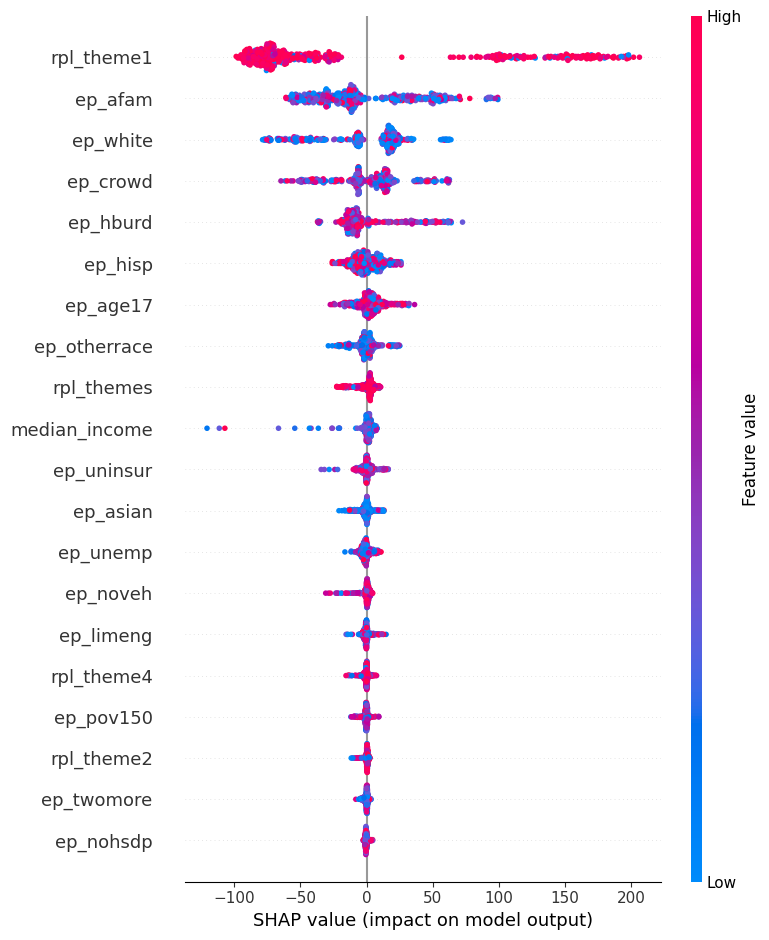

In [ ]:
explainer = shap.Explainer(model_rfr_svi.predict, X)
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

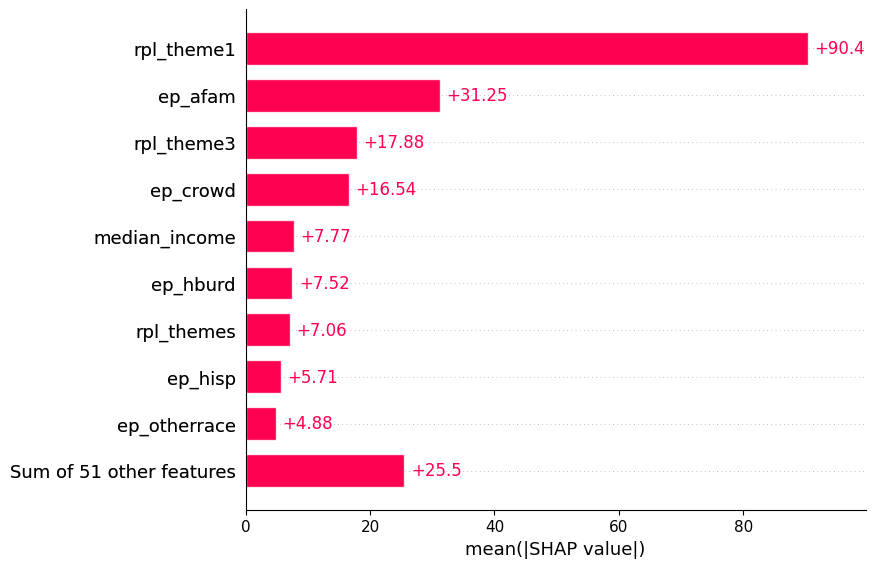

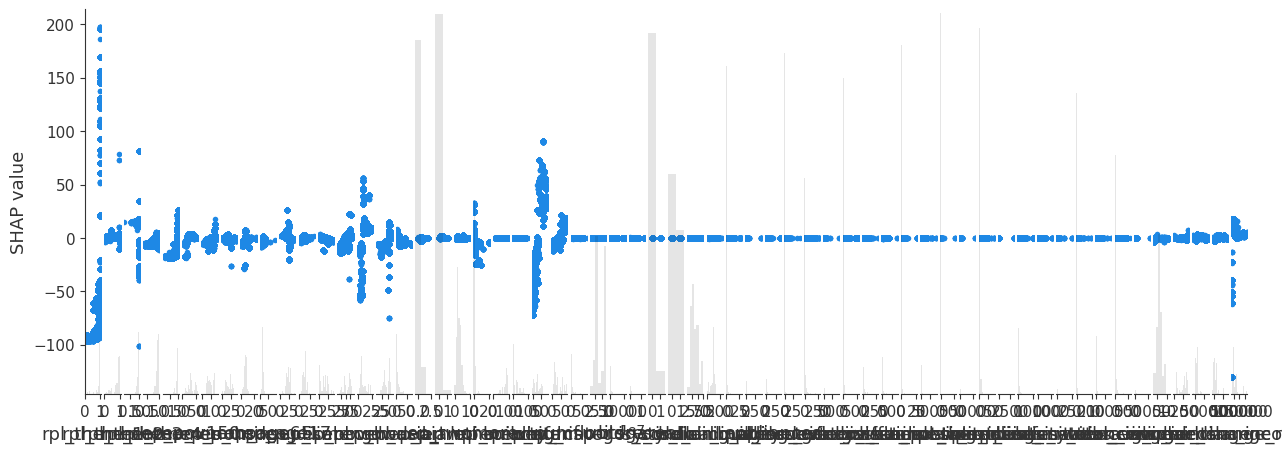

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

shap.plots.scatter(shap_values)

In [ ]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

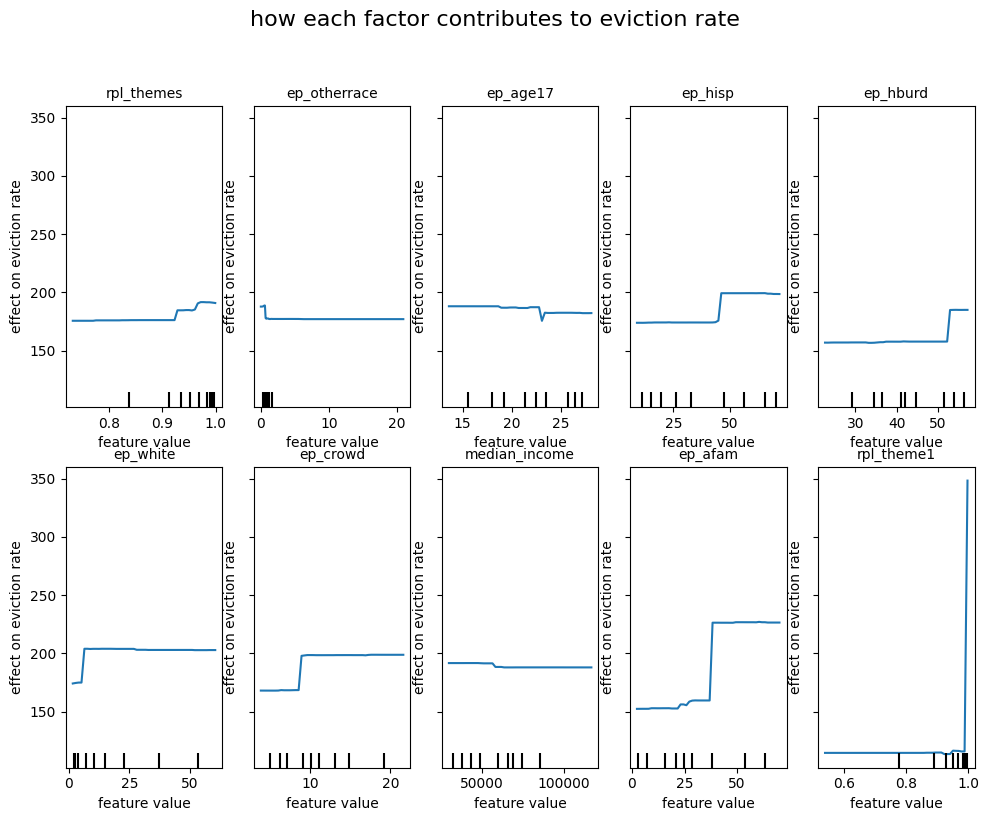

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Building Level (full)**

In [ ]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [ ]:
# idr_evi_df_zipcode = idr_evi_df.drop_duplicates(subset=['zipcode'])

In [ ]:
idr_evi_df.shape

(66395, 140)

In [ ]:
X= idr_evi_df[all_vars]
y= idr_evi_df['average_year_eviction_count(building)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_svi.score(X_test, y_test)

0.9596512832574647

PermutationExplainer explainer: 501it [05:40,  1.43it/s]


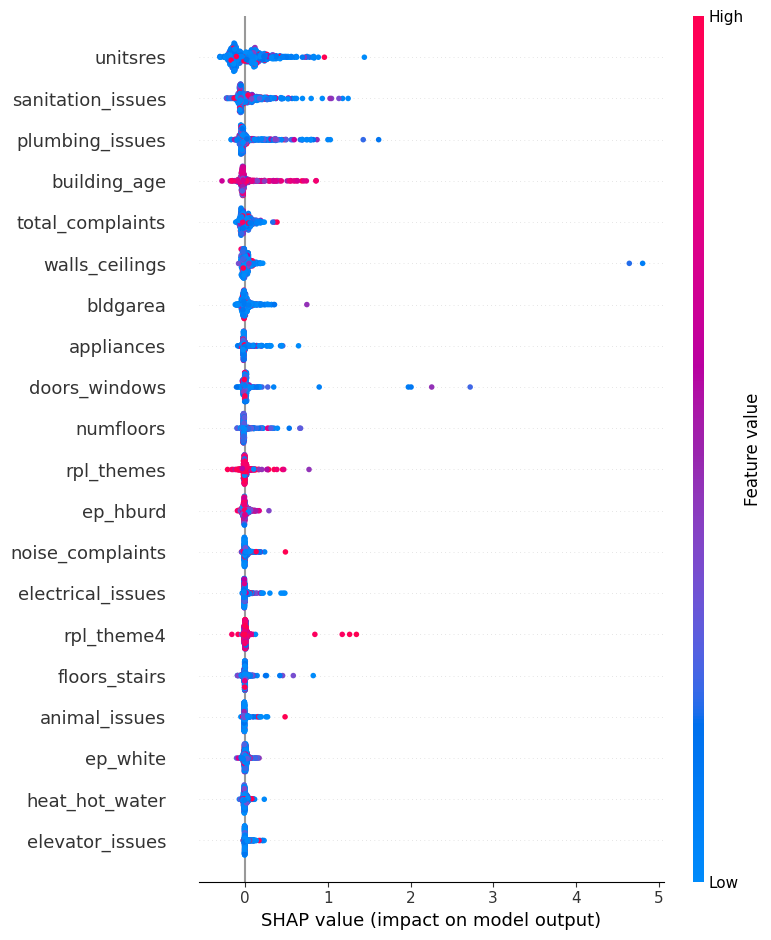

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

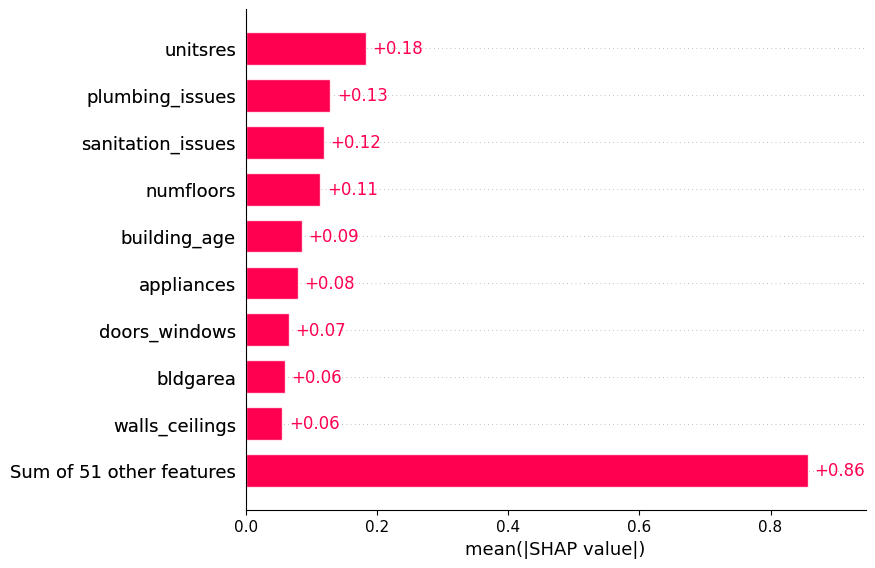

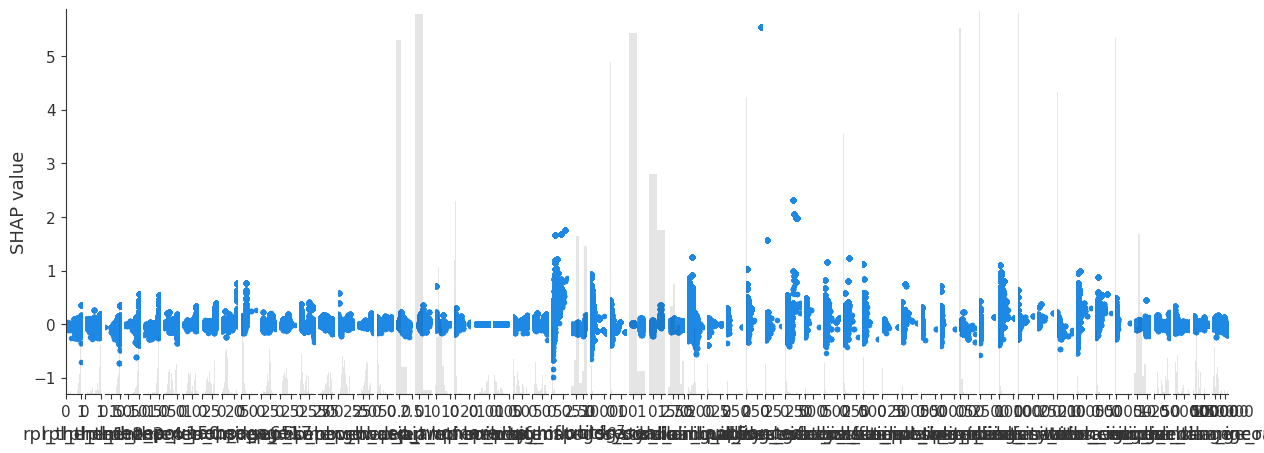

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [ ]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

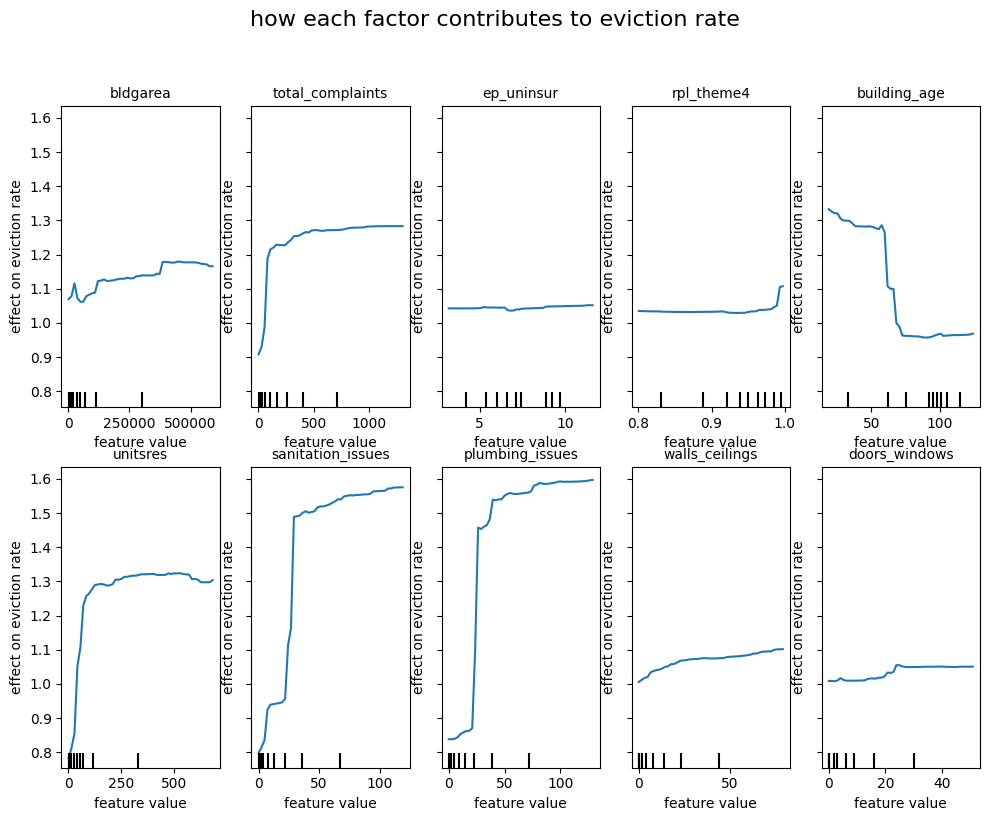

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

In [ ]:
# shap.dependence_plot(
#     "ep_asian",
#     shap_values,
#     X_test,
#     feature_names=X_test.columns,
#     interaction_index="auto"
# )

# **correlation test**

In [ ]:
# idr_evi_df[all_vars]

In [ ]:
# idr_evi_df.rename(columns= {'mediaon_income': 'median_income'})
# idr_evi_df.rename(columns = {'mediaon_income': 'median_income'})

In [ ]:
len(all_vars)

60

In [ ]:
idr_evi_df['median_income'] = idr_evi_df['median_income']*(-1)

In [ ]:
df_spearman = idr_evi_df[['average_year_eviction_count(building)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

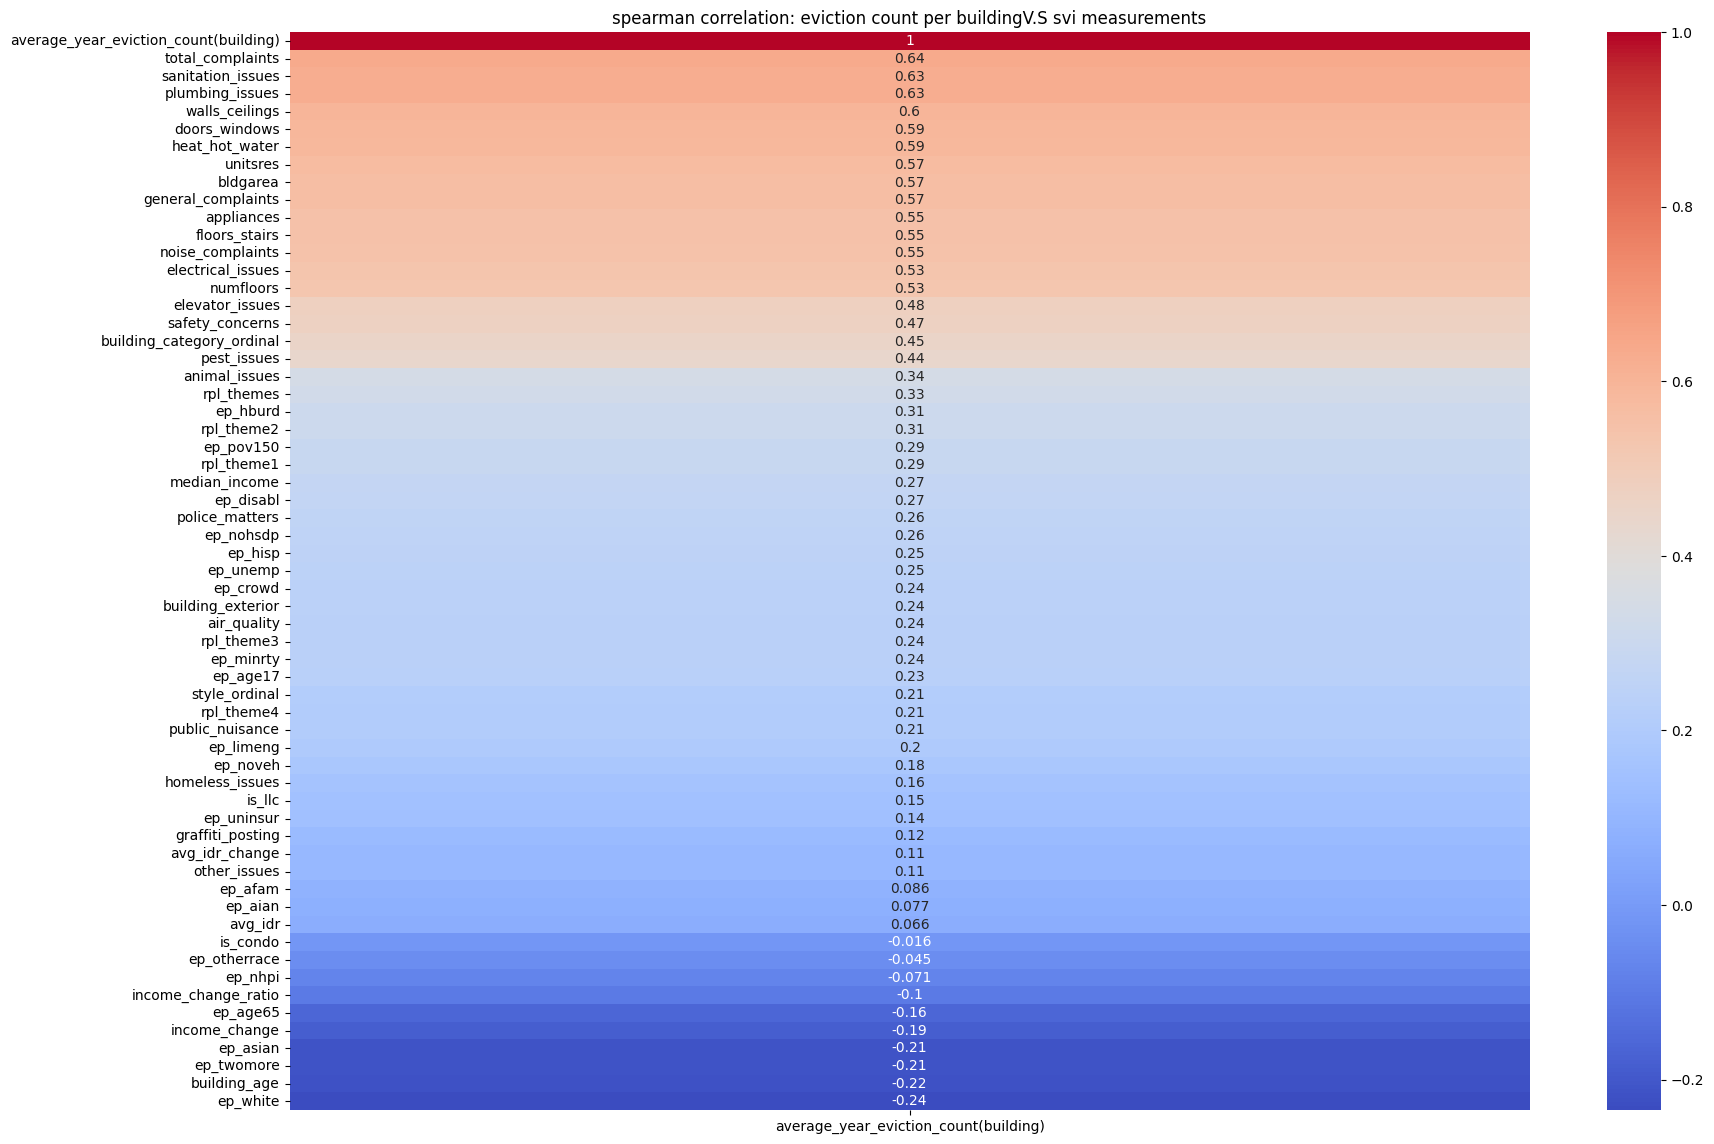

In [ ]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count(building)']].sort_values(by='average_year_eviction_count(building)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per buildingV.S svi measurements')
plt.show()

In [ ]:
# corr_matrix[['average_year_eviction_count(building)']]

In [ ]:
df_spearman = idr_evi_df[['average_year_eviction_count_per_zipcode(z)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

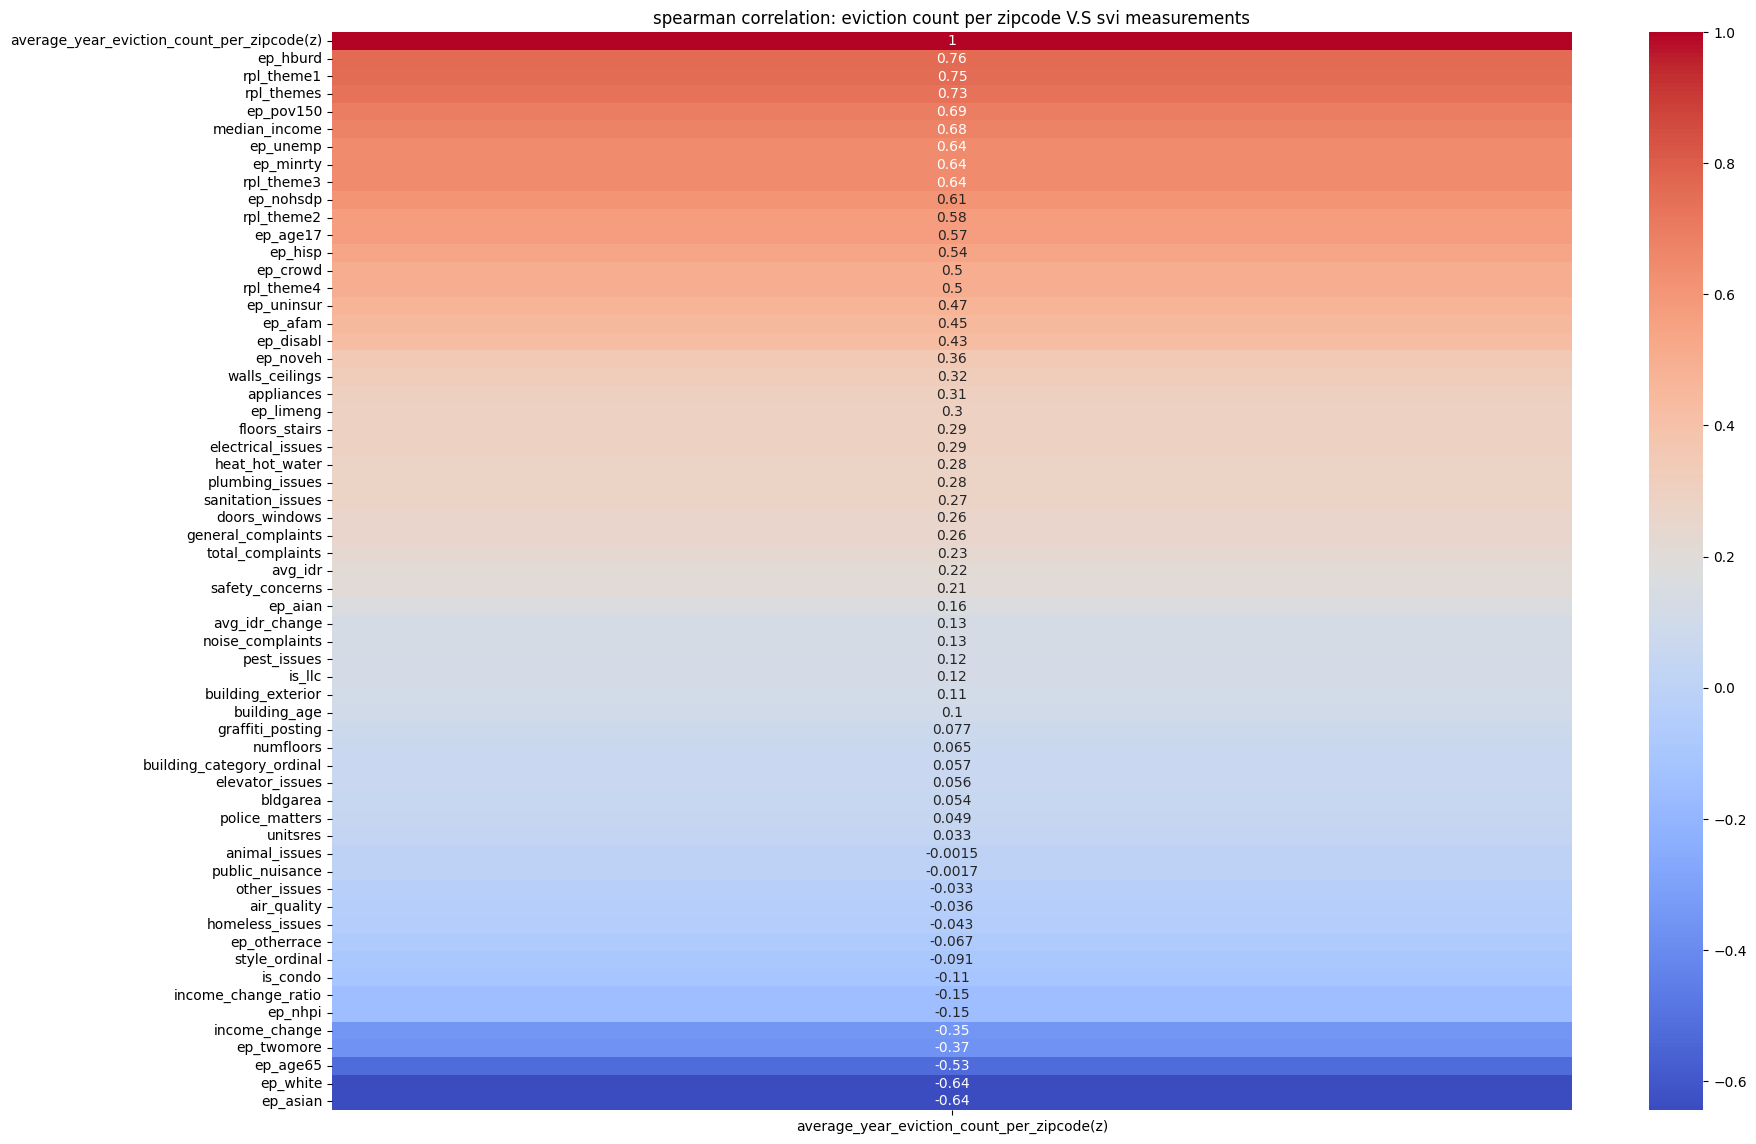

In [ ]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count_per_zipcode(z)']].sort_values(by='average_year_eviction_count_per_zipcode(z)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per zipcode V.S svi measurements')
plt.show()

In [ ]:
df_spearman = idr_evi_df[['eviction_count'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

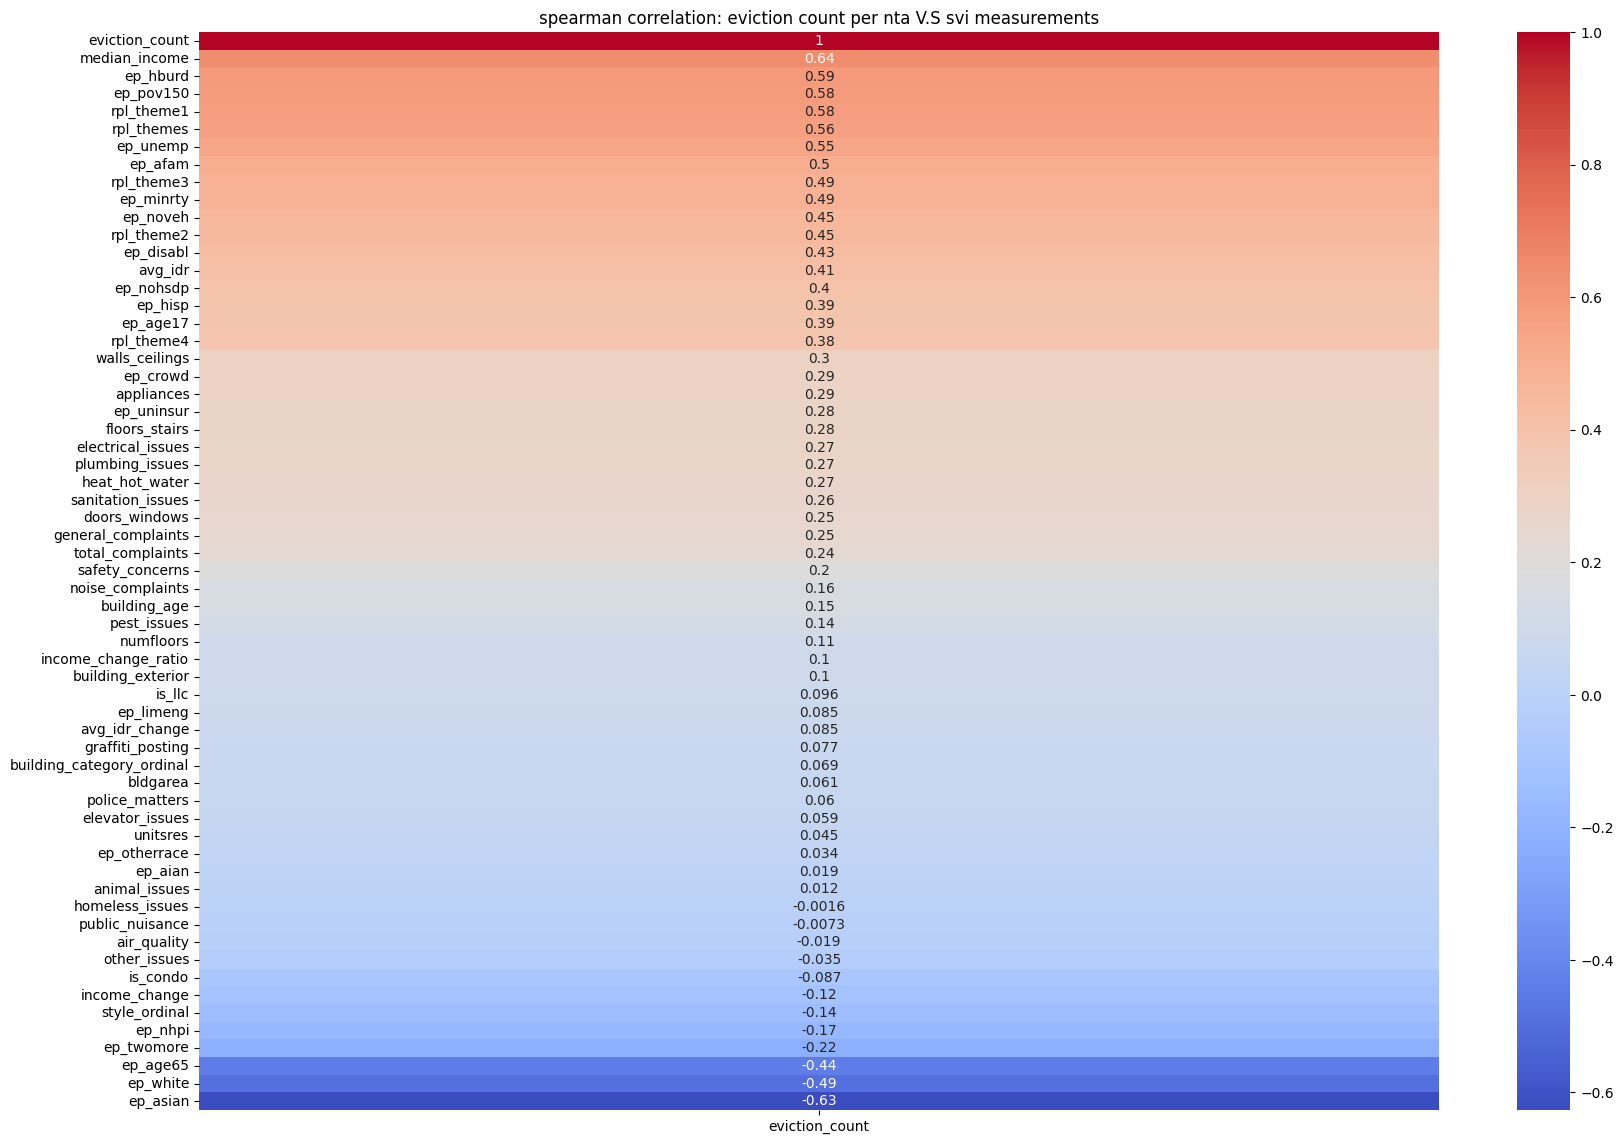

In [ ]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count']].sort_values(by='eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per nta V.S svi measurements')
plt.show()

In [ ]:
# average_year_eviction_count_per_unit(building)

In [ ]:
df_spearman = idr_evi_df[['average_year_eviction_count_per_unit(building)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

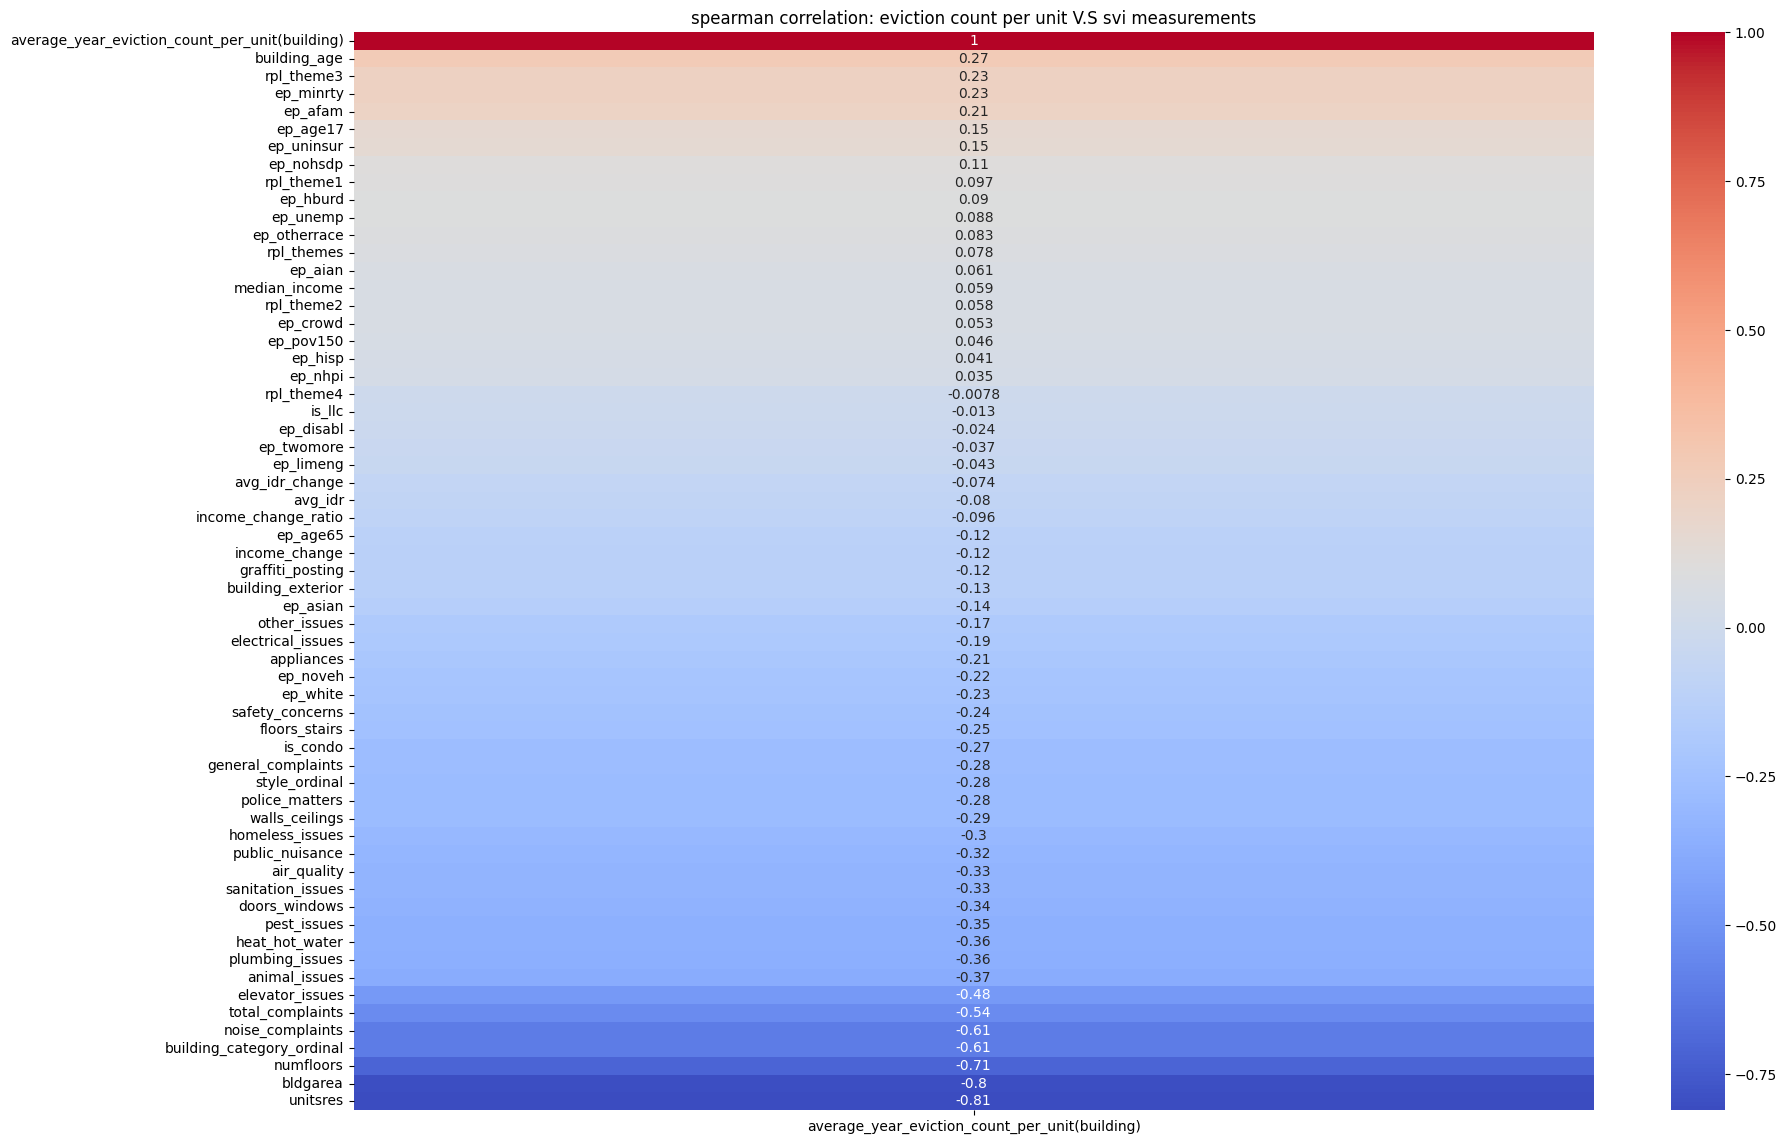

In [ ]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count_per_unit(building)']].sort_values(by='average_year_eviction_count_per_unit(building)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per unit V.S svi measurements')
plt.show()